In [1]:
# import os

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')


In [2]:
from config import *
from encoder import *
from decoder import *
from data import *
from vital import *
from train import *
from eval import *
from augmentor import *
from describer import *
from masker import *
print("using device: ", device)
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# import pkg_resources
# print(pkg_resources.get_distribution('python-calamine').version)



Random seed set to 333
using device:  cpu


In [3]:
# ---- (customize) update configs ----
overwrite = True
model_name = 'testtest'
text_config['cl']['die7d'] = True # udpate text_config here if needed
text_config['split'] = True
text_config['demo']['gre'] = True
text_config['demo']['apgar_mage'] = True
model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    model_name = model_name,
    ts_aug = False, # Data settings
    ts_subseq = False,
    ts_augsub = False,
    downsample_size = 100,
    balance = False,
    block_target = False,
    embedded_dim = 32,
    batch_size = 2048, # Data loader settings
    ts_global_normalize = True,
    ts_local_normalize = False,# True,
    patience = 100, # Training settings
    num_saves = 20,
    num_epochs = 10000,
    init_lr = 1e-3,
    text_config = text_config,
    text_col_ls = ['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_apgar', 'demo_mother']
)
config_dict = get_config_dict()



In [4]:
# ---- ready original dataframes ----
# Train Data
df = pd.read_excel('../../data/PAS Challenge HR Data.xlsx', engine="calamine")
df.columns = df.columns.astype(str)
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df = label_death7d(df, df_y, id_col='VitalID')
df = df.merge(df_demo, on='VitalID', how='left')
df_desc = generate_descriptions_parallel(ts_df = df.loc[:, '1':'300'], id_df = df.loc[:, ['VitalID', 'VitalTime']])
df = df.merge(df_desc, on=['VitalID', 'VitalTime'], how='left')
df = text_gen_input_column(df, config_dict['text_config'])
df['rowid'] = df.index.to_series() 
df_train = df

# Test Data
df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
df_test = pd.read_excel('../../data/Test Data/Test HR Data.xlsx', sheet_name=0, engine="calamine") # test hr with description
df_test.columns = df_test.columns.astype(str)
df_test = label_death7d(df_test, df_y_test, id_col='TestID')
df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
df_test = df_test.merge(df_demo_test, on='TestID', how='left')
df_test['rowid'] = df_test.index.to_series()
df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
df_test['VitalTime'] = df_test['VitalTime'].astype(int)
rename_dict = {'TestID': 'VitalID'}
df_test = df_test.rename(columns=rename_dict)

df_desc_test = generate_descriptions_parallel(ts_df = df_test.loc[:, '1':'300'], id_df = df_test.loc[:, ['VitalID', 'VitalTime']])
df_test = df_test.merge(df_desc_test, on=['VitalID', 'VitalTime'], how='left')
df_test = text_gen_input_column(df_test, config_dict['text_config'])
df_test_org = df_test[df.columns]
df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org[config_dict['y_col']], random_state=config_dict['random_state']) 


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.3s
[Parallel(n_jobs=9)]: Done 4882 tasks      | elapsed:    5.0s
[Parallel(n_jobs=9)]: Done 36882 tasks      | elapsed:    8.9s
[Parallel(n_jobs=9)]: Done 65353 out of 65353 | elapsed:   12.3s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams. This infant is Female Black non-Hispanic. The Apgar5 scores 6. Mother is 21 years old.    Moderate variability.  Very low amount of consecutive increases. 

Available text columns:
['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_gender', 'demo_race', 'demo_ethnicity', 'demo_apgar', 'demo_mother', 'cl_die7d']

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    2.0s
[Parallel(n_jobs=9)]: Done 61182 tasks      | elapsed:    7.3s
[Parallel(n_jobs=9)]: Done 61570 out of 61570 | elapsed:    7.3s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams. This infant is Male non-Black non-Hispanic. The Apgar5 scores 9. Mother is 26 years old.    High variability.  Low amount of consecutive increases. 

Available text columns:
['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_gender', 'demo_race', 'demo_ethnicity', 'demo_apgar', 'demo_mother', 'cl_die7d']


In [5]:
# df_train, df_test = train_test_split(df_train, test_size=0.2, stratify=df_train[config_dict['y_col']], random_state=config_dict['random_state']) 
# ---- downsample negative class(es) ----
df_train = downsample_neg_levels(df_train, config_dict, config_dict['random_state'])
df_test = downsample_neg_levels(df_test, config_dict, config_dict['random_state'])

# ---- augment + balance train data----
# target_event_rate = len(df_test[df_test[config_dict['y_col']]==config_dict['y_levels'][0]])/len(df_test)
if config_dict['ts_aug']:
    df_train = augment_balance_data(df_train, 
                                    config_dict['y_levels'], 
                                    config_dict['y_col'], 
                                    config_dict, 
                                    pretrained_model_path='./pretrained/hr_vae_linear_medium.pth')
    df_test['augid'] = 0

# ---- created masked subsequences of each time series ----
if config_dict['ts_subseq']:
    df_train = subseq_raw_df(df_train,config_dict)
    df_test = subseq_raw_df(df_test,config_dict)
    # Fill nan with -1 
    df_train.loc[:, '1':'300'] = df_train.loc[:, '1':'300'].fillna(config_dict['ts_normalize_mean'])
    df_test.loc[:, '1':'300'] = df_test.loc[:, '1':'300'].fillna(config_dict['ts_normalize_mean'])


# ---- block or not ----
if not config_dict['block_target']:
    df_train['label'] = df_train.index.to_series()
    df_test['label'] = df_test.index.to_series()
else:
    if 'subid' in df_train.columns:
        if config_dict['ts_augsub']:
            # = get a subsequence then augment it multiple times
            df_train['label'] = df_train['rowid'].astype(int)*100 + df_train['subid'].astype(int)
            df_test['label'] = df_test['rowid'].astype(int)*100 + df_test['subid'].astype(int)
        else:
            # get unqiue subsequences for each augmentation
            df_train['label'] = df_train['rowid'].astype(int)*10000 + df_train['augid'].astype(int)*100 + df_train['subid'].astype(int)
            df_test['label'] = df_test['rowid'].astype(int)*10000 + df_test['augid'].astype(int)*100 + df_test['subid'].astype(int)

    else:
        df_train['label'] = df_train['rowid'].astype(int)
        df_test['label'] = df_test['rowid'].astype(int)


After downsampling:
cl_event
This infant will die in 7 days.     384
This infant will survive.           100
Name: count, dtype: int64
After downsampling:
cl_event
This infant will die in 7 days.     241
This infant will survive.           100
Name: count, dtype: int64


In [6]:
# ---- ready eval inputs ----
n_levels = len(config_dict['y_levels'])
mtype = "3d" if config_dict['3d'] else "2d"

for i in range(n_levels):
    df_train[f'true{i+1}'] = df_train[config_dict['y_col']].apply(lambda x: 1 if x == config_dict['y_levels'][i] else 0)
    df_train[f'text{i+1}'] = config_dict['y_pred_levels'][i]
for i in range(n_levels):
    df_test[f'true{i+1}'] = df_test[config_dict['y_col']].apply(lambda x: 1 if x == config_dict['y_levels'][i] else 0)
    df_test[f'text{i+1}'] = config_dict['y_pred_levels'][i]

evalinputs_train = EvalInputs(df_train, 
                            config_dict['text_encoder_name'], 
                            normalize_mean = config_dict['ts_normalize_mean'], 
                            normalize_std = config_dict['ts_normalize_std'],
                            y_true_cols = [f'true{i+1}' for i in range(n_levels)],
                            y_pred_cols = [f'text{i+1}' for i in range(n_levels)],
                            y_pred_cols_ls = config_dict['y_pred_cols_ls'],
                            mtype=mtype)
evalinputs_test = EvalInputs(df_test, 
                            config_dict['text_encoder_name'], 
                            normalize_mean = config_dict['ts_normalize_mean'], 
                            normalize_std = config_dict['ts_normalize_std'],
                            y_true_cols = [f'true{i+1}' for i in range(n_levels)],
                            y_pred_cols = [f'text{i+1}' for i in range(n_levels)],
                            y_pred_cols_ls = config_dict['y_pred_cols_ls'],
                            mtype=mtype)


print(df_train[config_dict['y_col']].value_counts())
print(df_test[config_dict['y_col']].value_counts())

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


cl_event
This infant will die in 7 days.     384
This infant will survive.           100
Name: count, dtype: int64
cl_event
This infant will die in 7 days.     241
This infant will survive.           100
Name: count, dtype: int64


In [7]:

output_dir = './results/'+model_name
model_path = output_dir+'/model.pth' 
eval_path = output_dir+'/evals.pth'
config_path = output_dir+'/config.pth'


if overwrite:
    # ------------------------- ready dataloaders ------------------------- 
    if config_dict['3d']:
        ts_f_train, tx_f_train_ls, labels_train = get_features3d(df_train,
                                                                config_dict['text_encoder_name'], 
                                                                config_dict['ts_normalize_mean'],
                                                                config_dict['ts_normalize_std'],
                                                                global_norm = config_dict['ts_global_normalize'],
                                                                local_norm = config_dict['ts_local_normalize'],
                                                                text_col_ls = config_dict['text_col_ls'])
        train_dataloader = VITAL3DDataset(ts_f_train, tx_f_train_ls, labels_train).dataloader(batch_size=config_dict['batch_size'])
        ts_f_test, tx_f_test_ls, labels_test = get_features3d(df_test, 
                                                              config_dict['text_encoder_name'], 
                                                              config_dict['ts_normalize_mean'],
                                                              config_dict['ts_normalize_std'],
                                                              global_norm = config_dict['ts_global_normalize'],
                                                              local_norm = config_dict['ts_local_normalize'],
                                                              text_col_ls = config_dict['text_col_ls'])
        test_dataloader = VITAL3DDataset(ts_f_test, tx_f_test_ls, labels_test).dataloader(batch_size=config_dict['batch_size'])
    else: 
        ts_f_train, tx_f_train, labels_train = get_features(df_train,
                                                            config_dict['text_encoder_name'], 
                                                            config_dict['ts_normalize_mean'],
                                                            config_dict['ts_normalize_std'],
                                                            global_norm = config_dict['ts_global_normalize'],
                                                            local_norm = config_dict['ts_local_normalize'])
        train_dataloader = VITALDataset(ts_f_train, tx_f_train, labels_train).dataloader(batch_size=config_dict['batch_size'])
        ts_f_test, tx_f_test, labels_test = get_features(df_test,
                                                         config_dict['text_encoder_name'], 
                                                         config_dict['ts_normalize_mean'],
                                                         config_dict['ts_normalize_std'],
                                                         global_norm = config_dict['ts_global_normalize'],
                                                         local_norm = config_dict['ts_local_normalize'])
        test_dataloader = VITALDataset(ts_f_test, tx_f_test, labels_test).dataloader(batch_size=config_dict['batch_size'])
 

## Test VAE

In [8]:
import importlib
import sys

# Add the script directory to Python path if needed
script_dir = "./"
if script_dir not in sys.path:
    sys.path.append(script_dir)

# Import modules
import encoder
import decoder
import vital
import train

# Function to reload modules
def reload_modules():
    importlib.reload(encoder)
    importlib.reload(decoder)
    importlib.reload(vital)
    importlib.reload(train)
    print("All modules reloaded successfully!")

# Reload modules
reload_modules()


All modules reloaded successfully!


In [9]:
if overwrite:    
    # ------------------------- ready model (customize) -------------------------
    # check if ts_f_dim is already in the memory
    if 'ts_f_dim' not in locals():
        # get the dimension out
        if config_dict['3d']:
            ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], 
                                                                config_dict['text_encoder_name'], 
                                                                config_dict['ts_normalize_mean'],
                                                                config_dict['ts_normalize_std'],
                                                                text_col_ls = config_dict['text_col_ls'])
        else:
            ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], 
                                                            config_dict['text_encoder_name'], 
                                                            config_dict['ts_normalize_mean'],
                                                            config_dict['ts_normalize_std'])
    
    ts_encoder = None
    ts_decoder = None
    # #--- custom ts encoder ---
    # e = MLPEncoder(
    #     ts_dim=ts_f_dim.shape[1], 
    #     output_dim=config_dict['embedded_dim']
    # )
    # ts_encoder = TSVAEEncoderWrapper(e)
    # # --- custom ts decoder ---
    # d = MLPDecoder(
    #     ts_dim=ts_f_dim.shape[1], 
    #     output_dim=config_dict['embedded_dim']
    # )
    # ts_decoder = TSVAEDecoderWrapper(d)
    

    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    
    # ------------------------- ready training -------------------------
    # optimizer = torch.optim.AdamW(model.parameters(), 
    #                               lr=config_dict['init_lr'])#, 
    #                             #   weight_decay=1e-4)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer,
    #     mode='min',           # Reduce LR when metric stops decreasing
    #     factor=0.8,          # Multiply LR by this factor
    #     patience=config_dict['patience'],#max(config_dict['patience'], config_dict['num_epochs']//100), # 1% of total epochs, minimum 20
    #     min_lr=1e-20,         # Don't reduce LR below this value
    #     threshold=1e-3
    # )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config_dict['init_lr'],
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=config_dict['patience'],       
        verbose=True,
        min_lr=1e-10,        
        threshold=1e-4,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=1.0, 
                             end=1.0, 
                             epochs=10000) # for the first 1000 epochs, favor reconstruction more


    train_eval_metrics_list = []
    test_eval_metrics_list = []
    train_losses = []
    test_losses = []

    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    # torch.save(config_dict, config_path)
    # overwrite = False # reset overwrite to False
   

Layer (type:depth-idx)                                                 Param #
VITAL3D                                                                1
├─TSVAEEncoder: 1-1                                                    --
│    └─Sequential: 2-1                                                 --
│    │    └─Linear: 3-1                                                38,528
│    │    └─LeakyReLU: 3-2                                             --
│    │    └─Linear: 3-3                                                16,512
│    │    └─LeakyReLU: 3-4                                             --
│    └─Linear: 2-2                                                     4,128
│    └─Linear: 2-3                                                     4,128
├─TextEncoderWithAttention: 1-2                                        32
│    └─ModuleList: 2-4                                                 --
│    │    └─Sequential: 3-5                                            1,595,552
│    │    └─S

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [10]:
train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                train_dataloader,
                                                test_dataloader, 
                                                optimizer, 
                                                scheduler,
                                                kl_annealer,
                                                num_epochs=100000, 
                                                train_type='vae')

beta: 1.0
Epoch [1/100000]
	Training Loss: 344.754913
	Testing Loss: 371.193695
	Learning Rate: 0.001000000
beta: 1.0
Epoch [2/100000]
	Training Loss: 340.239349
	Testing Loss: 364.258514
	Learning Rate: 0.001000000
beta: 1.0
Epoch [3/100000]
	Training Loss: 333.898560
	Testing Loss: 352.663605
	Learning Rate: 0.001000000
beta: 1.0
Epoch [4/100000]
	Training Loss: 322.825195
	Testing Loss: 333.817047
	Learning Rate: 0.001000000
beta: 1.0
Epoch [5/100000]
	Training Loss: 305.668823
	Testing Loss: 308.100128
	Learning Rate: 0.001000000
beta: 1.0
Epoch [6/100000]
	Training Loss: 281.309570
	Testing Loss: 275.612396
	Learning Rate: 0.001000000
beta: 1.0
Epoch [7/100000]
	Training Loss: 251.347290
	Testing Loss: 241.212875
	Learning Rate: 0.001000000
beta: 1.0
Epoch [8/100000]
	Training Loss: 220.567200
	Testing Loss: 213.747375
	Learning Rate: 0.001000000
beta: 1.0
Epoch [9/100000]
	Training Loss: 195.810272
	Testing Loss: 199.113998
	Learning Rate: 0.001000000
beta: 1.0
Epoch [10/100000]


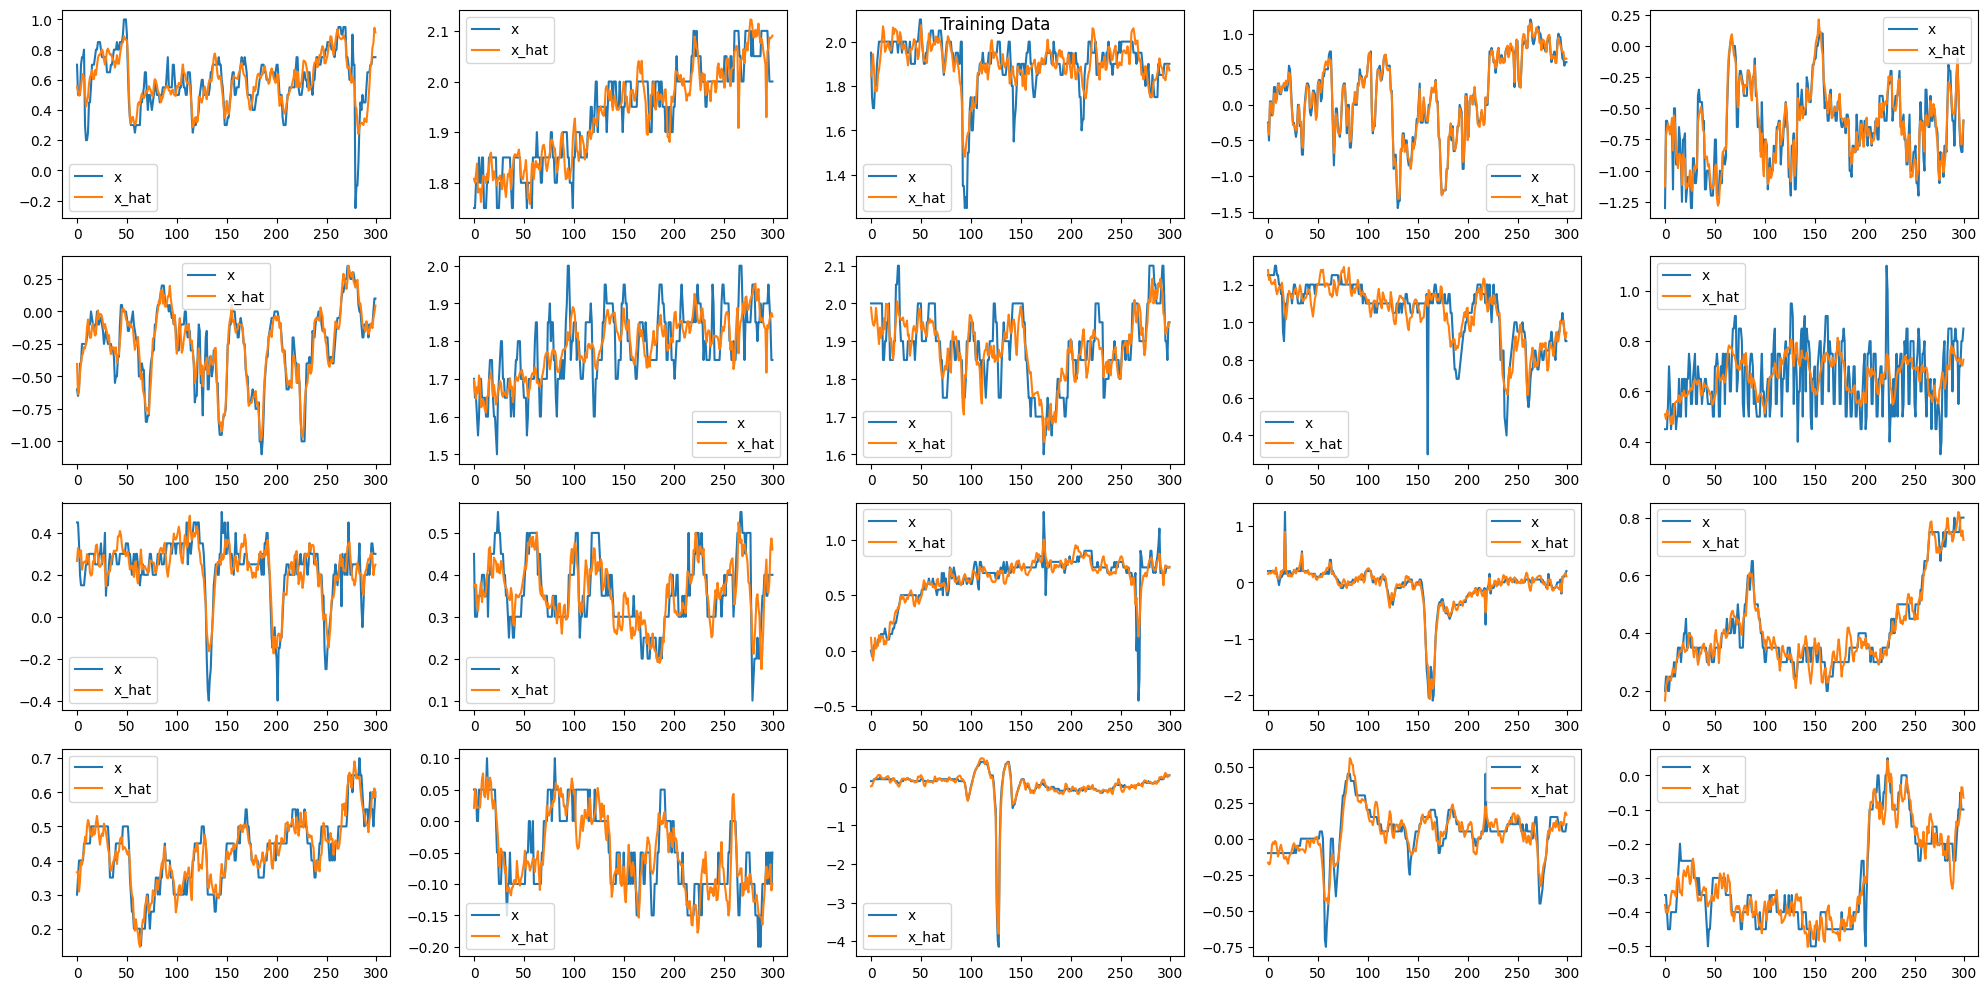

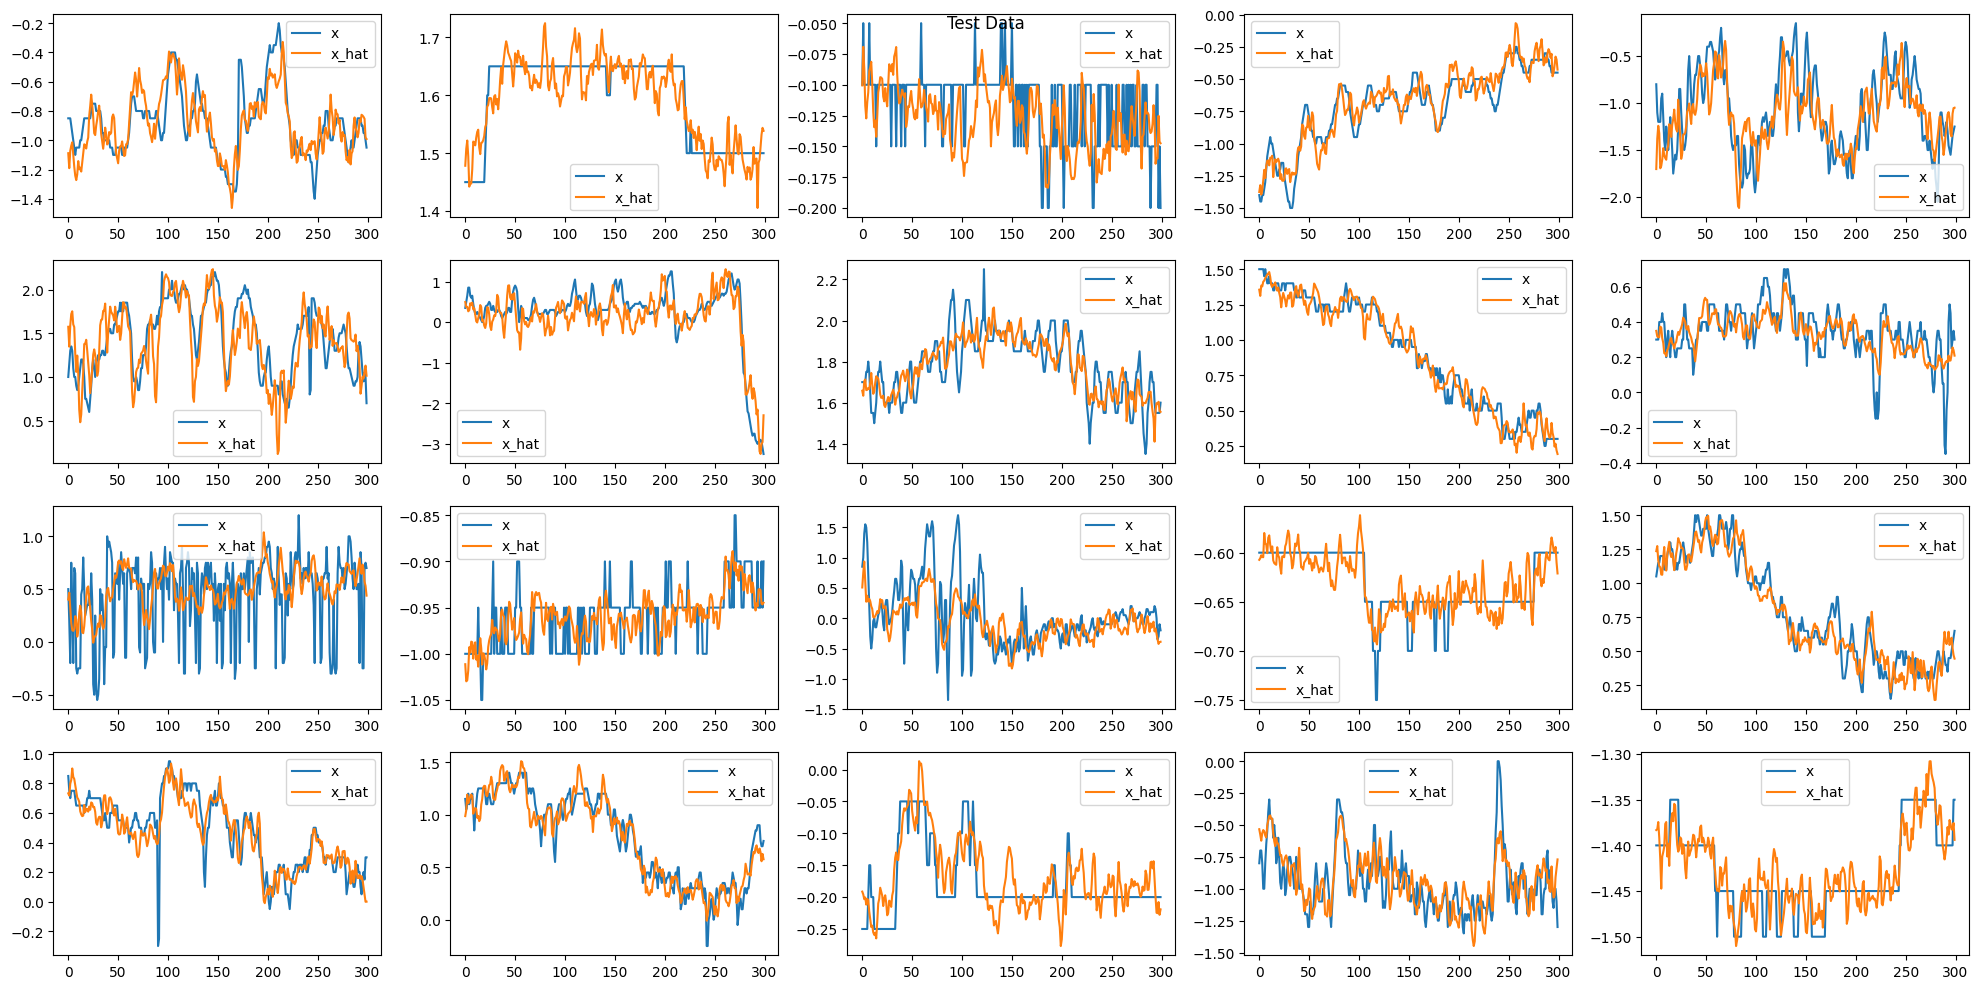

In [11]:
model.eval()
b = 0
fig, axes = plt.subplots(4, 5, figsize=(20, 10), facecolor='white')
for i in range(b, b+20):
    x, text_features, _ = train_dataloader.dataset[i]  # Assuming third element is labels
    x = x.unsqueeze(0).to(model.device)  # [1, ts_dim]
    text_features = [text_feature.unsqueeze(0).to(model.device) for text_feature in text_features]  # [1, text_dim]
            
    _, x_hat, mean, log_var = model(x, text_features)    
    axes[i//5, i%5].plot(x[0].cpu().numpy(), label='x')
    axes[i//5, i%5].plot(x_hat[0].cpu().detach().numpy(), label='x_hat')
    axes[i//5, i%5].legend()
plt.tight_layout()
fig.suptitle('Training Data')
plt.show()

fig, axes = plt.subplots(4, 5, figsize=(20, 10), facecolor='white')
for i in range(b, b+20):
    x, text_features, _ = test_dataloader.dataset[i]  # Assuming third element is labels
    x = x.unsqueeze(0).to(model.device)  # [1, ts_dim]
    text_features = [text_feature.unsqueeze(0).to(model.device) for text_feature in text_features]  # [1, text_dim]
    
    _, x_hat, mean, log_var = model(x, text_features)    
    axes[i//5, i%5].plot(x[0].cpu().numpy(), label='x')
    axes[i//5, i%5].plot(x_hat[0].cpu().detach().numpy(), label='x_hat')
    axes[i//5, i%5].legend()
plt.tight_layout()  
fig.suptitle('Test Data')
plt.show()


Layer (type:depth-idx)                                                 Param #
VITAL3D                                                                1
├─TSVAEEncoder: 1-1                                                    --
│    └─Sequential: 2-1                                                 --
│    │    └─Linear: 3-1                                                77,056
│    │    └─LeakyReLU: 3-2                                             --
│    │    └─Linear: 3-3                                                32,896
│    │    └─LeakyReLU: 3-4                                             --
│    └─Linear: 2-2                                                     4,128
│    └─Linear: 2-3                                                     4,128
├─TextEncoderWithAttention: 1-2                                        32
│    └─ModuleList: 2-4                                                 --
│    │    └─Sequential: 3-5                                            1,595,552
│    │    └─S

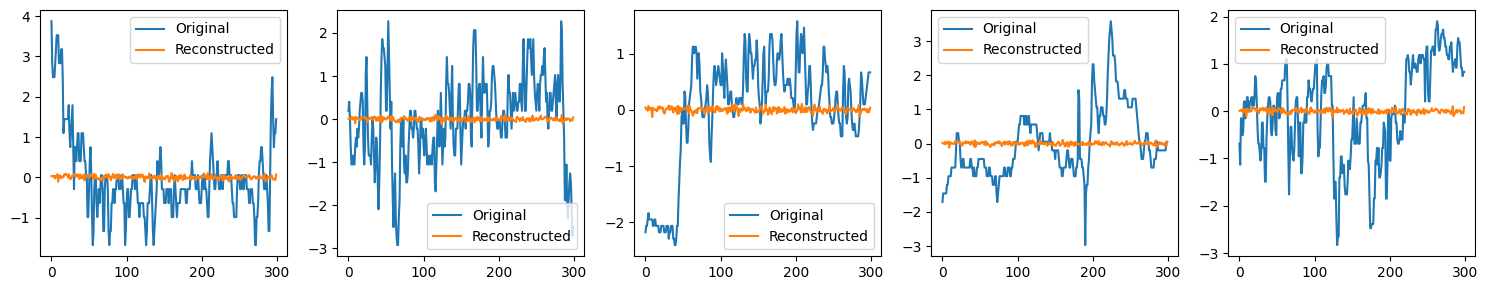

Epoch 10/10000:
  Loss: 262.6345 (Recon: 262.6291, KL: 26.9819)
  Beta: 0.0002, LR: 0.001000
Epoch 20/10000:
  Loss: 221.7140 (Recon: 221.7073, KL: 16.7203)
  Beta: 0.0004, LR: 0.001000
Epoch 30/10000:
  Loss: 203.3669 (Recon: 203.3550, KL: 19.9323)
  Beta: 0.0006, LR: 0.001000
Epoch 40/10000:
  Loss: 186.8846 (Recon: 186.8650, KL: 24.3862)
  Beta: 0.0008, LR: 0.001000
Epoch 50/10000:
  Loss: 174.6786 (Recon: 174.6501, KL: 28.5110)
  Beta: 0.0010, LR: 0.001000
Epoch 60/10000:
  Loss: 161.0038 (Recon: 160.9636, KL: 33.4472)
  Beta: 0.0012, LR: 0.001000
Epoch 70/10000:
  Loss: 152.0583 (Recon: 152.0063, KL: 37.0916)
  Beta: 0.0014, LR: 0.001000
Epoch 80/10000:
  Loss: 141.6386 (Recon: 141.5709, KL: 42.3250)
  Beta: 0.0016, LR: 0.001000
Epoch 90/10000:
  Loss: 130.3820 (Recon: 130.2941, KL: 48.8483)
  Beta: 0.0018, LR: 0.001000
Epoch 100/10000:
  Loss: 120.5518 (Recon: 120.4411, KL: 55.3591)
  Beta: 0.0020, LR: 0.001000
Epoch 110/10000:
  Loss: 113.0266 (Recon: 112.8871, KL: 63.3970)
  Be

KeyboardInterrupt: 

In [86]:
# Initialize model and move to device
# model = VAE_Linear_Medium(seq_len=300)
import torch.optim as optim

model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# 1. Keep optimizer settings
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

# 2. Modify scheduler for slower decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.9,          # More gentle reduction (was 0.8)
    patience=100,        # Much more patience (was 50)
    verbose=True,
    min_lr=1e-6,        # Higher min_lr (was 1e-20)
    threshold=1e-4,      # More sensitive to improvements
    cooldown=20          # Add cooldown period after each reduction
)

def train_epoch(model, dataloader, optimizer, beta=0.01):  # Added beta parameter
    model.train()
    total_recon_loss = 0
    total_kl_loss = 0
    total_loss = 0
    
    for batch_idx, (ts, text_features, labels) in enumerate(dataloader):
        
        
        ts = ts.to(device)
        if isinstance(text_features, list):
            text_features = [t.to(device) for t in text_features]
        else:
            text_features = text_features.to(device)
        labels = labels.to(device)

        _, ts_hat, mean, log_var = model(ts, text_features)

        # Modified loss computation
        recon_loss = F.mse_loss(ts_hat, ts, reduction='sum') / ts.size(0)  # Per-sample loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1).mean()
        
        # Use beta-VAE formulation
        loss = recon_loss + beta * kl_loss  # Added beta weight
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        total_loss += loss.item()
    
    num_batches = len(dataloader)
    return (total_loss / num_batches, 
            total_recon_loss / num_batches, 
            total_kl_loss / num_batches)

# Training loop with beta annealing
num_epochs = 10000
beta_start = 0.0 # Start training with beta=0 (focus only on reconstruction)
beta_end = 0 # End with beta=0.01 (final balance between reconstruction and KL)
losses = []

print("Starting training...")
for epoch in range(num_epochs):
    # Gradually increase beta
    beta = min(beta_end, beta_start + (beta_end - beta_start) * epoch / 5000) # Gradually increase beta over 100 epochs (slowly introduce KL regularization)
    
    # Train for one epoch
    avg_loss, avg_recon, avg_kl = train_epoch(model, train_dataloader, optimizer, beta)
    losses.append([avg_loss, avg_recon, avg_kl])
    
    scheduler.step(avg_loss)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}:')
        print(f'  Loss: {avg_loss:.4f} (Recon: {avg_recon:.4f}, KL: {avg_kl:.4f})')
        print(f'  Beta: {beta:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Add validation visualization
        if epoch % 1000 == 0:
            model.eval()
            with torch.no_grad():
                x = next(iter(train_dataloader))[0][:5].to(device)
                text_features = next(iter(train_dataloader))[1][:5]#.to(device)
                text_features = [ttt.to(device) for ttt in text_features]
                _, x_hat, _, _ = model(x, text_features)
                
                plt.figure(figsize=(15, 3))
                for i in range(5):
                    plt.subplot(1, 5, i+1)
                    plt.plot(x[i].cpu(), label='Original')
                    plt.plot(x_hat[i].cpu(), label='Reconstructed')
                    plt.legend()
                plt.tight_layout()
                plt.show()

# Plot losses
losses = np.array(losses)
plt.figure(figsize=(10, 5))
plt.plot(losses[:, 0], label='Total Loss')
plt.plot(losses[:, 1], label='Recon Loss')
plt.plot(losses[:, 2], label='KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')  # Added log scale
plt.show()


# Loss of Variance/Detail: The reconstructed signals (orange) are much smoother than the original signals (blue), suggesting the VAE is learning to output averaged/mean values rather than capturing the true variability in the data. This is a common problem known as "posterior collapse" where the VAE produces overly smooth reconstructions.

Layer (type:depth-idx)                                                 Param #
VITAL3D                                                                1
├─TSVAEEncoder: 1-1                                                    --
│    └─Sequential: 2-1                                                 --
│    │    └─Linear: 3-1                                                77,056
│    │    └─LeakyReLU: 3-2                                             --
│    │    └─Linear: 3-3                                                131,584
│    │    └─LeakyReLU: 3-4                                             --
│    │    └─Linear: 3-5                                                262,656
│    │    └─LeakyReLU: 3-6                                             --
│    │    └─Linear: 3-7                                                131,328
│    │    └─LeakyReLU: 3-8                                             --
│    │    └─Linear: 3-9                                                32,896
│    │    └

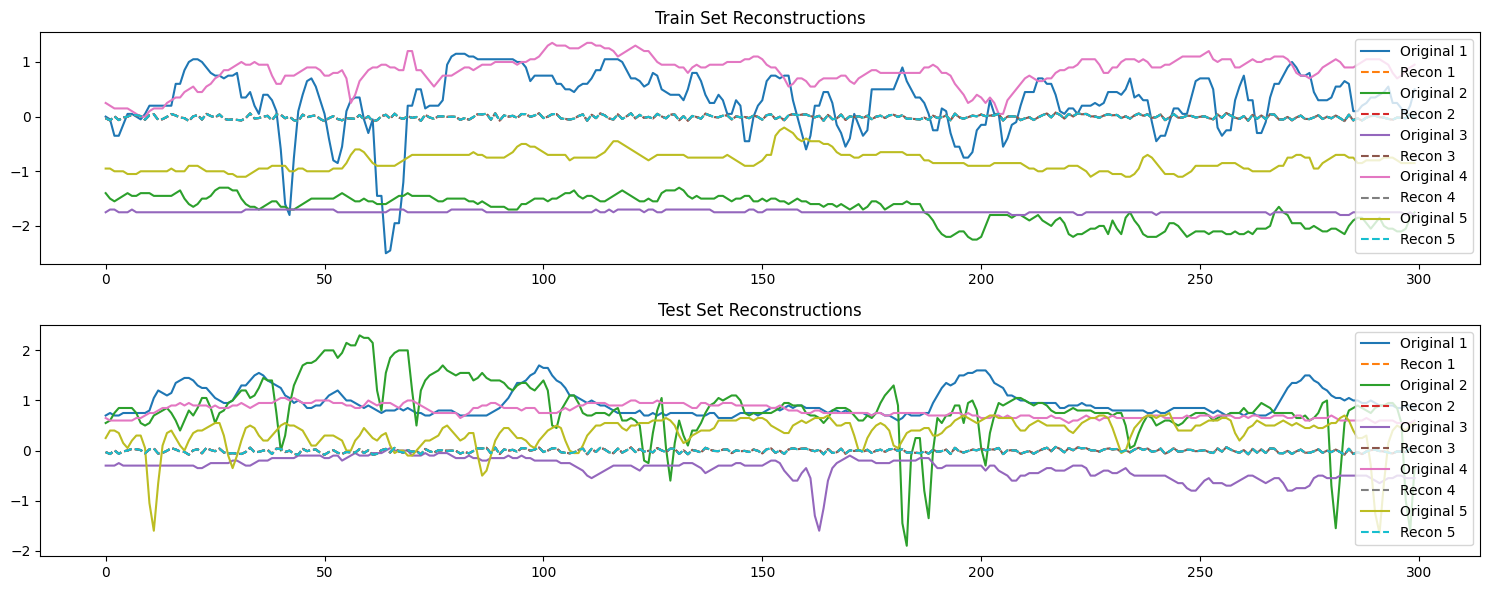

Epoch 10/100000:
  Train Loss: 851.8251 (Recon: 851.7349, KL: 450.8460)
  Test Loss:  241.2743 (Recon: 241.2247, KL: 247.7864)
  Beta: 0.0002, LR: 0.001000
Epoch 20/100000:
  Train Loss: 288.8889 (Recon: 288.8110, KL: 194.8851)
  Test Loss:  371.9712 (Recon: 371.8941, KL: 192.7812)
  Beta: 0.0004, LR: 0.001000
Epoch 30/100000:
  Train Loss: 44.3824 (Recon: 44.3293, KL: 88.5236)
  Test Loss:  59.3830 (Recon: 59.3315, KL: 85.7703)
  Beta: 0.0006, LR: 0.001000
Epoch 40/100000:
  Train Loss: 32.4205 (Recon: 32.3668, KL: 67.0549)
  Test Loss:  53.1801 (Recon: 53.1325, KL: 59.4299)
  Beta: 0.0008, LR: 0.001000
Epoch 50/100000:
  Train Loss: 34.3528 (Recon: 34.2669, KL: 85.8794)
  Test Loss:  49.2198 (Recon: 49.1413, KL: 78.5034)
  Beta: 0.0010, LR: 0.001000
Epoch 60/100000:
  Train Loss: 30.1353 (Recon: 30.0413, KL: 78.3513)
  Test Loss:  48.6304 (Recon: 48.5259, KL: 87.1104)
  Beta: 0.0012, LR: 0.001000
Epoch 70/100000:
  Train Loss: 31.0842 (Recon: 30.9511, KL: 95.1189)
  Test Loss:  50.68

KeyboardInterrupt: 

In [45]:
# Initialize model and move to device
# model = VAE_Linear_Medium(seq_len=300)
import torch.optim as optim

model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
ts_encoder = model.ts_encoder
ts_decoder = model.ts_decoder 

# concate them in to one model
class VAE_From_VITAL(nn.Module):
    def __init__(self, ts_encoder, ts_decoder):
        """Initialize VAE using existing encoder and decoder from VITAL
        
        Args:
            ts_encoder: Encoder from VITAL3D model
            ts_decoder: Decoder from VITAL3D model
        """
        super(VAE_From_VITAL, self).__init__()
        self.encoder = ts_encoder
        self.decoder = ts_decoder
        print(nn_summary(self))
        
    def forward(self, x):
        """Forward pass
        
        Args:
            x: Input tensor of shape [batch_size, seq_len]
            
        Returns:
            tuple:
                - x_hat: Reconstructed output
                - mean: Mean of latent distribution
                - log_var: Log variance of latent distribution
        """
        # Get latent representation using VITAL's encoder
        z, mean, log_var = self.encoder(x)
        
        # Decode using VITAL's decoder
        x_hat = self.decoder(z)
        
        return x_hat, mean, log_var

# Usage:
# Initialize the model using VITAL's encoder and decoder
model = VAE_From_VITAL(ts_encoder, ts_decoder)
model = model.to(device)

# 1. Keep optimizer settings
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

# 2. Modify scheduler for slower decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.9,          # More gentle reduction (was 0.8)
    patience=100,        # Much more patience (was 50)
    verbose=True,
    min_lr=1e-6,        # Higher min_lr (was 1e-20)
    threshold=1e-4,      # More sensitive to improvements
    cooldown=20          # Add cooldown period after each reduction
)
def train_epoch(model, dataloader, optimizer, beta=0.01):  # Added beta parameter
    model.train()
    total_recon_loss = 0
    total_kl_loss = 0
    total_loss = 0
    
    for batch_idx, (x, _, _) in enumerate(dataloader):
        x = x.to(device)
        x_hat, mean, log_var = model(x)
        
        # Modified loss computation
        recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)  # Per-sample loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1).mean()
        
        # Use beta-VAE formulation
        loss = recon_loss + beta * kl_loss  # Added beta weight
        
        optimizer.zero_grad()
        loss.backward()
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        total_loss += loss.item()
    
    num_batches = len(dataloader)
    return (total_loss / num_batches, 
            total_recon_loss / num_batches, 
            total_kl_loss / num_batches)


def evaluate(model, dataloader, beta=0.01):
    model.eval()
    total_recon_loss = 0
    total_kl_loss = 0
    total_loss = 0
    
    with torch.no_grad():
        for batch_idx, (x, _, _) in enumerate(dataloader):
            x = x.to(device)
            x_hat, mean, log_var = model(x)
            
            # Same loss computation as training
            recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)
            kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1).mean()
            loss = recon_loss + beta * kl_loss
            
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            total_loss += loss.item()
    
    num_batches = len(dataloader)
    return (total_loss / num_batches, 
            total_recon_loss / num_batches, 
            total_kl_loss / num_batches)


# Training loop with beta annealing
num_epochs = 100000
beta_start = 0.0 # Start training with beta=0 (focus only on reconstruction)
beta_end = 0.1 # End with beta=0.01 (final balance between reconstruction and KL)
losses = []

print("Starting training...")
for epoch in range(num_epochs):
    # Gradually increase beta
    beta = min(beta_end, beta_start + (beta_end - beta_start) * epoch / 5000) # Gradually increase beta over 100 epochs (slowly introduce KL regularization)
    
    # Train for one epoch
    train_loss, train_recon, train_kl = train_epoch(model, train_dataloader, optimizer, beta)
    # Evaluate on test set
    test_loss, test_recon, test_kl = evaluate(model, test_dataloader, beta)
    
    train_losses.append([train_loss, train_recon, train_kl])
    test_losses.append([test_loss, test_recon, test_kl])
    
    # Use test loss for scheduler
    scheduler.step(test_loss)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f})')
        print(f'  Test Loss:  {test_loss:.4f} (Recon: {test_recon:.4f}, KL: {test_kl:.4f})')
        print(f'  Beta: {beta:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Visualization every 5000 epochs
        if epoch % 5000 == 0:
            model.eval()
            with torch.no_grad():
                # Train set reconstructions
                x_train = next(iter(train_dataloader))[0][:5].to(device)
                x_train_hat, _, _ = model(x_train)
                
                # Test set reconstructions
                x_test = next(iter(test_dataloader))[0][:5].to(device)
                x_test_hat, _, _ = model(x_test)
                
                plt.figure(figsize=(15, 6))
                # Train reconstructions
                plt.subplot(2, 1, 1)
                plt.title('Train Set Reconstructions')
                for i in range(5):
                    plt.plot(x_train[i].cpu(), label=f'Original {i+1}')
                    plt.plot(x_test_hat[i].cpu(), '--', label=f'Recon {i+1}')
                plt.legend()
                
                # Test reconstructions
                plt.subplot(2, 1, 2)
                plt.title('Test Set Reconstructions')
                for i in range(5):
                    plt.plot(x_test[i].cpu(), label=f'Original {i+1}')
                    plt.plot(x_test_hat[i].cpu(), '--', label=f'Recon {i+1}')
                plt.legend()
                
                plt.tight_layout()
                plt.show()


Starting training...
Epoch 0/100000:
  Train Loss: 340.9984 (Recon: 340.9984, KL: 0.0727)
  Test Loss:  335.6557 (Recon: 335.6557, KL: 0.0761)
  Beta: 0.0000, LR: 0.000500


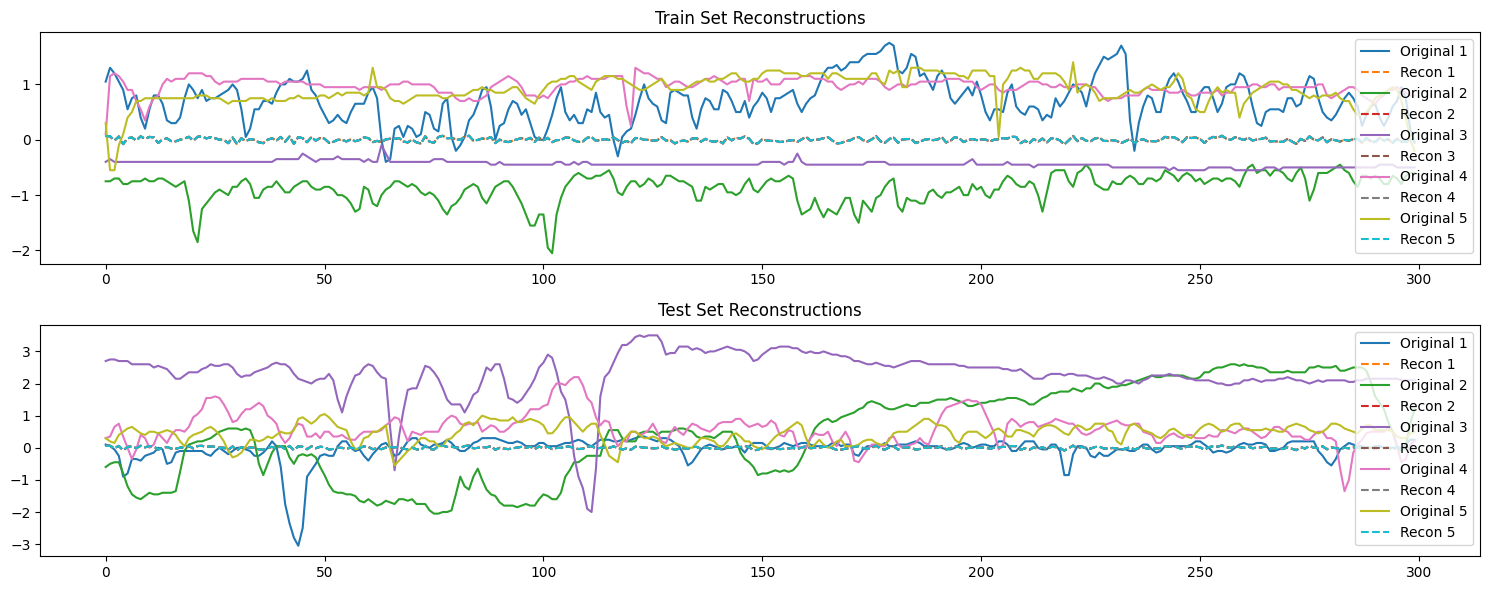

Epoch 10/100000:
  Train Loss: 223.1775 (Recon: 223.1709, KL: 32.8898)
  Test Loss:  159.8147 (Recon: 159.8005, KL: 70.9016)
  Beta: 0.0002, LR: 0.000500
Epoch 20/100000:
  Train Loss: 80.5413 (Recon: 80.4517, KL: 224.2049)
  Test Loss:  64.3028 (Recon: 64.2502, KL: 131.4682)
  Beta: 0.0004, LR: 0.000500
Epoch 30/100000:
  Train Loss: 60.2063 (Recon: 60.1050, KL: 168.7627)
  Test Loss:  68.2217 (Recon: 68.1345, KL: 145.2384)
  Beta: 0.0006, LR: 0.000500
Epoch 40/100000:
  Train Loss: 33.4690 (Recon: 33.3788, KL: 112.7128)
  Test Loss:  52.0894 (Recon: 52.0070, KL: 102.9119)
  Beta: 0.0008, LR: 0.000500
Epoch 50/100000:
  Train Loss: 31.6165 (Recon: 31.4889, KL: 127.5613)
  Test Loss:  48.3603 (Recon: 48.2440, KL: 116.2408)
  Beta: 0.0010, LR: 0.000500
Epoch 60/100000:
  Train Loss: 29.1546 (Recon: 29.0041, KL: 125.4309)
  Test Loss:  47.3542 (Recon: 47.2119, KL: 118.5886)
  Beta: 0.0012, LR: 0.000500
Epoch 70/100000:
  Train Loss: 28.9760 (Recon: 28.8095, KL: 118.9077)
  Test Loss:  47

KeyboardInterrupt: 

In [46]:
# Initialize model and move to device
model = VAE_Linear_Medium(seq_len=300)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 1. Better optimizer settings
optimizer = optim.AdamW(  # Changed to AdamW
    model.parameters(),
    lr=5e-4,             # Lower initial learning rate
    weight_decay=1e-4    # Add weight decay
)

# 2. Better scheduler settings
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.7,          # Gentler reduction
    patience=20,         # More patience
    verbose=True,
    min_lr=1e-5,
    threshold=1e-3       # Less stringent threshold
)

def train_epoch(model, dataloader, optimizer, beta=0.01):  # Added beta parameter
    model.train()
    total_recon_loss = 0
    total_kl_loss = 0
    total_loss = 0
    
    for batch_idx, (x, _, _) in enumerate(dataloader):
        x = x.to(device)
        x_hat, mean, log_var = model(x)
        
        # Modified loss computation
        recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)  # Per-sample loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1).mean()
        
        # Use beta-VAE formulation
        loss = recon_loss + beta * kl_loss  # Added beta weight
        
        optimizer.zero_grad()
        loss.backward()
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        total_loss += loss.item()
    
    num_batches = len(dataloader)
    return (total_loss / num_batches, 
            total_recon_loss / num_batches, 
            total_kl_loss / num_batches)


def evaluate(model, dataloader, beta=0.01):
    model.eval()
    total_recon_loss = 0
    total_kl_loss = 0
    total_loss = 0
    
    with torch.no_grad():
        for batch_idx, (x, _, _) in enumerate(dataloader):
            x = x.to(device)
            x_hat, mean, log_var = model(x)
            
            recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)
            kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1).mean()
            loss = recon_loss + beta * kl_loss
            
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            total_loss += loss.item()
    
    num_batches = len(dataloader)
    return (total_loss / num_batches, 
            total_recon_loss / num_batches, 
            total_kl_loss / num_batches)


# Training loop with beta annealing
num_epochs = 100000
beta_start = 0.0 # Start training with beta=0 (focus only on reconstruction)
beta_end = 0.1 # End with beta=0.01 (final balance between reconstruction and KL)
train_losses = []
test_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    beta = min(beta_end, beta_start + (beta_end - beta_start) * epoch / 5000)
    
    # Train and evaluate
    train_loss, train_recon, train_kl = train_epoch(model, train_dataloader, optimizer, beta)
    test_loss, test_recon, test_kl = evaluate(model, test_dataloader, beta)
    
    # Store losses
    train_losses.append([train_loss, train_recon, train_kl])
    test_losses.append([test_loss, test_recon, test_kl])
    
    # Use test loss for scheduler
    scheduler.step(test_loss)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f})')
        print(f'  Test Loss:  {test_loss:.4f} (Recon: {test_recon:.4f}, KL: {test_kl:.4f})')
        print(f'  Beta: {beta:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        if epoch % 5000 == 0:
            model.eval()
            with torch.no_grad():
                # Train reconstructions
                x_train = next(iter(train_dataloader))[0][:5].to(device)
                x_train_hat, _, _ = model(x_train)
                
                # Test reconstructions
                x_test = next(iter(test_dataloader))[0][:5].to(device)
                x_test_hat, _, _ = model(x_test)
                
                # Visualize both train and test reconstructions
                plt.figure(figsize=(15, 6))
                
                # Train reconstructions
                plt.subplot(2, 1, 1)
                plt.title('Train Set Reconstructions')
                for i in range(5):
                    plt.plot(x_train[i].cpu(), label=f'Original {i+1}')
                    plt.plot(x_train_hat[i].cpu(), '--', label=f'Recon {i+1}')
                plt.legend()
                
                # Test reconstructions
                plt.subplot(2, 1, 2)
                plt.title('Test Set Reconstructions')
                for i in range(5):
                    plt.plot(x_test[i].cpu(), label=f'Original {i+1}')
                    plt.plot(x_test_hat[i].cpu(), '--', label=f'Recon {i+1}')
                plt.legend()
                
                plt.tight_layout()
                plt.show()

# Plot train vs test losses
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

plt.figure(figsize=(15, 5))

# Total Loss
plt.subplot(1, 3, 1)
plt.title('Total Loss')
plt.plot(train_losses[:, 0], label='Train')
plt.plot(test_losses[:, 0], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')

# Reconstruction Loss
plt.subplot(1, 3, 2)
plt.title('Reconstruction Loss')
plt.plot(train_losses[:, 1], label='Train')
plt.plot(test_losses[:, 1], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')

# KL Loss
plt.subplot(1, 3, 3)
plt.title('KL Loss')
plt.plot(train_losses[:, 2], label='Train')
plt.plot(test_losses[:, 2], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()
